# Exploratory Data Analysis

After extracting the music data from multiple sources, we will now begin exploring the pre-cleaned music dataset. For more information how it was extracted and wrangled, please feel free to explore any of the the *_scripts* folders and read the README.md file. As a refresher, let's re-examine the music files that constitute our dataset.

In [1]:
import os
import pandas as pd

Here are the five genres in my dataset. Let's count how many tracks are there in each of the categories.

In [2]:
cwd = os.getcwd()
categories = [
    genre 
    for genre in os.listdir('genres/') 
    if genre != '.DS_Store'
]

count = 0
for genre in categories:
    music_file_directory = cwd + '/genres/' + genre
    music_file_list = [
        file 
        for file in os.listdir(music_file_directory) 
        if file != '.DS_Store'
    ]
    
    genre_count = len(music_file_list)
    count += genre_count
    print('{:20s}: {:10d}'.format(genre, genre_count))

print("-"*32)
print('{:20s}: {:10d}'.format('Total Tracks', count))

hip-hop             :        582
soundtrack          :        582
pop                 :        540
rock                :        540
jazz                :        564
--------------------------------
Total Tracks        :       2808


For reference, we will create a pandas dataframe that represents the metadata of the dataset. For now, the dataframe has two columns, the first will be the file location, and the second will be the track's genre.

In [3]:
file_locations = []
genres = []

for genre in categories:
    genre_file_directory = cwd + '/genres/' + genre
    genre_file_list = [
        file 
        for file in os.listdir(genre_file_directory) 
        if file != '.DS_Store'
    ]
    
    for file in genre_file_list:
        file_location = genre_file_directory + '/' + file
        file_locations.append(file_location)
        genres.append(genre)
        
music_df = pd.DataFrame(
    {
        'file_location': file_locations,
        'genre': genres
    }
)

music_df.to_csv('metadata.csv', index=False)

Since we have those two columns in our table, the question now is how can we extract numerical features from a music file so that we can feed it into a machine learning classification model.

## Mel-Spectrogram

After reading through the signal processing research, there is a way to convert a sound wave to its image representation, called the mel-spectrogram. For more information about the mel-spectrogram, as well as how it is generated, feel free to read through this link https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53. For now, let's demonstrate with an example on how we can extract the mel-spectrogram from a music file. Below is a list of useful functions for the Mel Spectrogram analysis.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from librosa import load, power_to_db
from librosa.display import specshow
from librosa.feature import melspectrogram
from random import sample

def display_melspectrogram(file_location):
    y, sampling_rate = load(file_location)
    melspectrogram_db = power_to_db(
        melspectrogram(y=y, sr=sampling_rate), 
        ref=np.max
    )
    
    fig, ax = plt.subplots()
    img = specshow(melspectrogram_db, x_axis='time',y_axis='mel', sr=sampling_rate, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    
    genre, filename = tuple(file_location.split("/")[-2:])
    ax.set(title='Mel-frequency Spectrogram For %s/%s' %(genre, filename))
    
    plt.show()
    
def display_sample_melspectrograms(genre, n_samples = 3):
    file_locations = list(music_df[music_df.genre == genre].file_location)
    samples = sample(file_locations, n_samples)
    
    for file_location in samples:
        display_melspectrogram(file_location)

Here are some mel-spectrogram plots below:

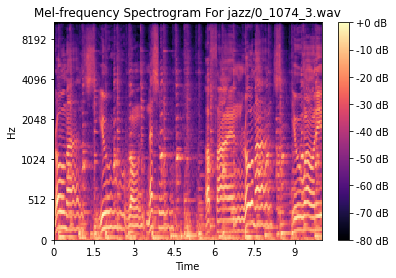

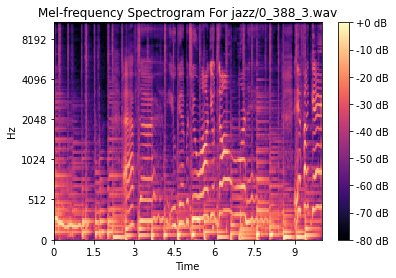

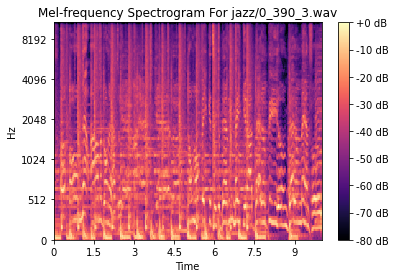

In [23]:
#Randomly sample three Jazz songs from our dataset.
display_sample_melspectrograms('jazz')

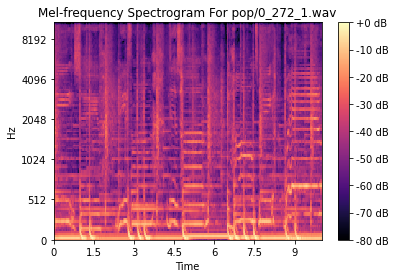

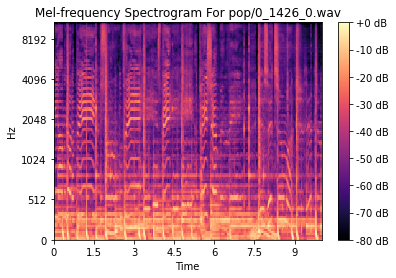

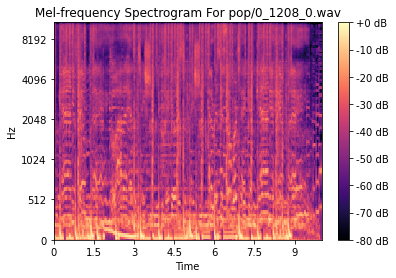

In [6]:
#Randomly sample three Pop songs from our dataset.
display_sample_melspectrograms('pop')

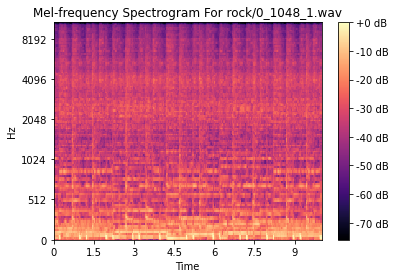

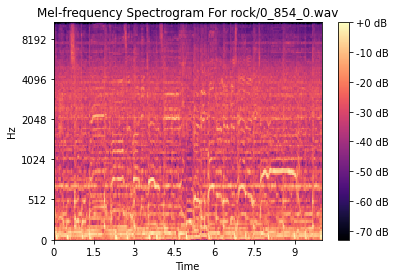

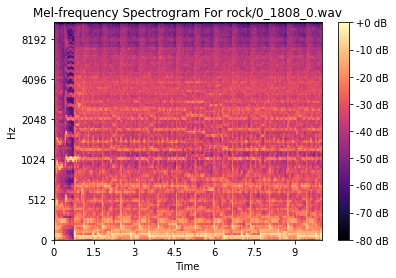

In [7]:
#Randomly sample three Rock songs from our dataset.
display_sample_melspectrograms('rock')

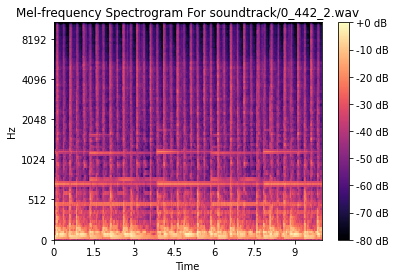

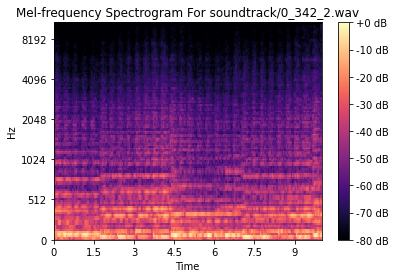

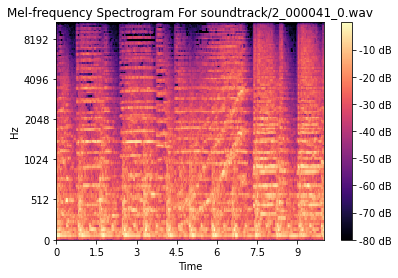

In [8]:
#Randomly sample three soundtrack songs.
display_sample_melspectrograms('soundtrack')

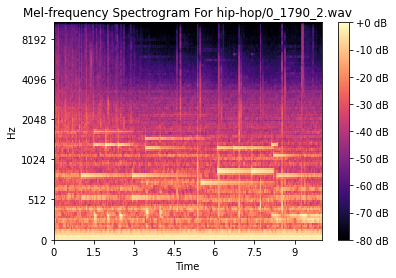

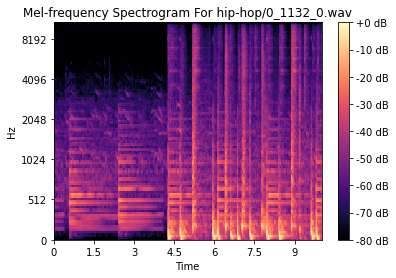

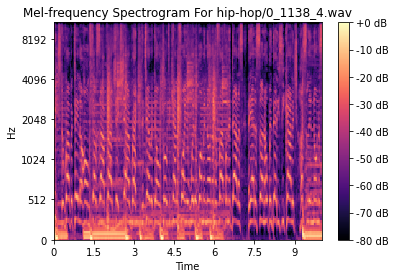

In [9]:
#Randomly sample three hip-hop songs.
display_sample_melspectrograms('hip-hop')

After running through the above code multiple times, and listening to the above tracks, here is what is noticable when analyzing multiple mel-spectrograms:
 * Squiggly lines indicate there is a vocalist in the track. All genres, except soundtracks, have squiggly lines in their mel-spectrograms.
 * Multiple vertical lines indicate that the track has a consistent beat. This can be seen in most hip hop music.
 * Horizontal lines lines indicate a prolonged note in a track. This is most seen in soundtrack, and jazz.
 * The brightness of the mel-spectrogram indicates the track's volume. In other words, brighter mel-spectrograms indicates louder tracks. When looking at the mel-spectrograms for rock music, they tend to have very uniform and bright regions.

Other than the mel-spectrogram, there are other hand crafted features that can be extracted from a music file. Here are some examples:

**Time Domain Features**
 * Tempo
 * Zero Crossing Rate
 
**Frequency Domain Feature(s)**
 * Spectral Flatness (coming soon ...)

Before we can do this, let's create a function that can plot kernel density estimators.

In [10]:
import seaborn as sns

def plot_kde(feature, genres, colors):
    genres_colors = zip(genres, colors)
    
    for genre, color in zip(genres, colors):
        genre_tracks = music_df[music_df.genre == genre]
        sns.kdeplot(genre_tracks[feature], shade=True, color=color, label=genre)
        
    plt.xlabel(feature)
    plt.ylabel("Probability Density")
    
    if len(list(genres_colors)) > 1:
        plt.title("KDE Plot")
        plt.legend()
    else:
        plt.title("KDE Plot (%s)" % genres[0])

    plt.show()

## Time Domain Features

### Tempo

For the purpose of this analysis, tempo is defined as the number of beats per minute. It indicates the pace of a music track. Here is a function on how we can extract the song's tempo.

In [11]:
from librosa.beat import tempo
from librosa.onset import onset_strength

def extract_tempo(file_location):
    y, sampling_rate = load(file_location)
    onset_env = onset_strength(y, sr=sampling_rate)
    
    return float(tempo(onset_envelope=onset_env, sr=sampling_rate))

Let's add the tempo column to the metadata.

In [12]:
music_df['tempo'] = music_df.file_location.apply(extract_tempo)
music_df.to_csv('metadata.csv', index=False)

Aterwards, we will plot the KDE of the tempo for all five genres.

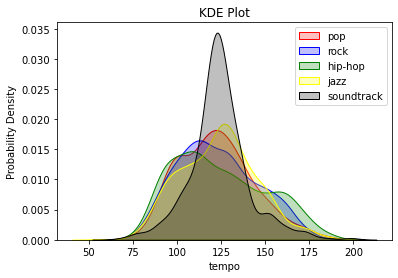

In [13]:
plot_kde('tempo', ['pop', 'rock', 'hip-hop', 'jazz', 'soundtrack'], ['red', 'blue', 'green', 'yellow', 'black'])

Notice that the most dominant curve in this plot is the KDE curve for soundtrack. By examining the KDE curve for soundtrack, the curve indicates that most soundtracks are closely clustered around a tempo of 125 beats per minute, compared to the other four genres. Moreover, the spread for soundtrack's tempo is the smallest out of all genres in the dataset. Let's remove soundtrack curve so that we can examine the other four genres.

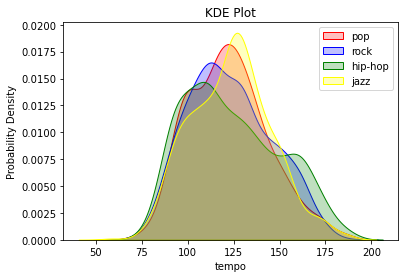

In [14]:
plot_kde('tempo', ['pop', 'rock', 'hip-hop', 'jazz'], ['red', 'blue', 'green', 'yellow'])

All four curves seem similar to one another. Notice that pop and jazz curves are closely resemble a normal distribution curve, while hip-hop and rock curves are slightly skewed to the left. 

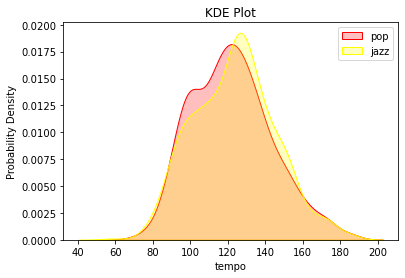

In [15]:
plot_kde('tempo', ['pop', 'jazz'], ['red', 'yellow'])

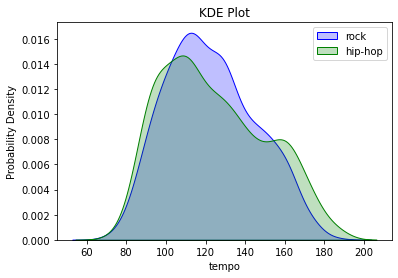

In [16]:
plot_kde('tempo', ['rock', 'hip-hop'], ['blue', 'green'])

### Zero Crossing Rate

The zero-crossing rate (ZCR) is the rate at which a signal changes from positive to zero to negative or from negative to zero to positive. Its value has been widely used in both speech recognition and music information retrieval, being a key feature to classify percussive sounds (see https://en.wikipedia.org/wiki/Zero-crossing_rate for more information). Additionally, the zero crossing rate is also used to indicate whether there is human speech in a sound wave. Here is a function on how to extract the zero crossing rate from a music file.

In [17]:
from librosa import zero_crossings

def extract_zcr(file_location):
    y, sampling_rate = load(file_location)
    return sum(zero_crossings(y)) / len(zero_crossings(y))

Let's add the zero_crossing_rate to our column.

In [18]:
music_df['zero_crossing_rate'] = music_df.file_location.apply(extract_zcr)
music_df.to_csv('metadata.csv', index=False)

Afterwards, let's plot the KDE of the zero crossing rate for all five genres.

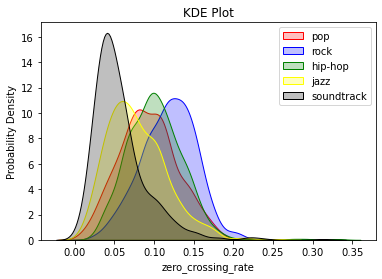

In [19]:
plot_kde('zero_crossing_rate', ['pop', 'rock', 'hip-hop', 'jazz', 'soundtrack'], ['red', 'blue', 'green', 'yellow', 'black'])

As you can see in this graph, soundtrack and jazz music have on average the lowest zero crossing rate, while the other three genres have the highest zero_crossing rates. This could indicate that soundtrack and jazz music, in our music dataset, does not have a lot of human speach.

## Frequency Domain Features

### Spectral Flatness